In [1]:
# Step 1: Check GPU Availability and Setup
import tensorflow as tf
print("GPU Available:", tf.config.list_physical_devices('GPU'))

# Enable memory growth for GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth enabled")
    except RuntimeError as e:
        print(e)

# # Step 2: Install Required Packages
# !pip install numpy pandas scikit-learn matplotlib tensorflow

# Step 3: Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow import keras
import multiprocessing as mp
from concurrent.futures import ProcessPoolExecutor

# Step 4: Data Loading and Preprocessing
def load_and_preprocess_data():
    # # Mount Google Drive if needed
    # from google.colab import drive
    # drive.mount('/content/drive')

    # Read the dataset
    df = pd.read_csv('C:/Users/hafiz/Downloads/cardio_train.csv')

    # Data cleaning
    df = df.dropna()

    # Use a smaller sample for faster training
    df = df.sample(frac=0.5, random_state=42)

    # Split features and target
    X = df.drop('cardio', axis=1)
    y = df['cardio']

    # Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    return X_train, X_test, y_train, y_test

# Step 5: Neural Network Implementation with GPU Optimization
class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size):
        # Use GPU-optimized architecture
        self.model = keras.Sequential([
            keras.layers.Input(shape=(input_size,)),
            keras.layers.Dense(hidden_size//2, activation='relu'),
            keras.layers.Dense(output_size, activation='sigmoid')
        ])

        # Add early stopping
        self.early_stopping = keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )

        # Use GPU-optimized optimizer
        self.model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

    def train(self, X_train, y_train, epochs=100, batch_size=32):
        history = self.model.fit(
            X_train, y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_split=0.2,
            verbose=0,
            callbacks=[self.early_stopping]
        )
        return history

    def evaluate(self, X_test, y_test):
        return self.model.evaluate(X_test, y_test, verbose=0)

# Step 6: PSO Implementation with GPU Support
class Particle:
    def __init__(self, dimensions):
        self.position = tf.random.uniform([dimensions], dtype=tf.float32)
        self.velocity = tf.random.uniform([dimensions], dtype=tf.float32)
        self.best_position = tf.identity(self.position)
        self.best_fitness = float('inf')

    def update_velocity(self, global_best, w, c1, c2):
        r1, r2 = tf.random.uniform([2], dtype=tf.float32)
        cognitive = c1 * r1 * (self.best_position - self.position)
        social = c2 * r2 * (global_best - self.position)
        self.velocity = w * self.velocity + cognitive + social

    def update_position(self):
        self.position = self.position + self.velocity
        self.position = tf.clip_by_value(self.position, 0, 1)

class PSO:
    def __init__(self, num_particles, dimensions):
        self.particles = [Particle(dimensions) for _ in range(num_particles)]
        self.global_best_position = None
        self.global_best_fitness = float('inf')
        self.v_max = 0.1

    def optimize(self, objective_function, max_iterations):
        for iteration in range(max_iterations):
            fitnesses = []
            for particle in self.particles:
                fitness = objective_function(particle.position)
                fitnesses.append(fitness)

            for particle, fitness in zip(self.particles, fitnesses):
                if fitness < particle.best_fitness:
                    particle.best_fitness = fitness
                    particle.best_position = tf.identity(particle.position)

                    if fitness < self.global_best_fitness:
                        self.global_best_fitness = fitness
                        self.global_best_position = tf.identity(particle.position)

            for particle in self.particles:
                particle.update_velocity(self.global_best_position, 0.7, 1.5, 1.5)
                particle.velocity = tf.clip_by_value(particle.velocity, -self.v_max, self.v_max)
                particle.update_position()

            if iteration % 5 == 0:
                print(f'Iteration {iteration+1}/{max_iterations}, Best Fitness: {self.global_best_fitness}')

        return self.global_best_position

# Step 7: PSO-NN Integration with GPU Optimization
class PSONeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.pso = PSO(num_particles=15, dimensions=5)

    def objective_function(self, hyperparameters):
        learning_rate = hyperparameters[0]
        batch_size = int(hyperparameters[1] * 64) + 64
        epochs = int(hyperparameters[2] * 20) + 10

        nn = NeuralNetwork(self.input_size, self.hidden_size, self.output_size)
        history = nn.train(X_train, y_train, epochs=epochs, batch_size=batch_size)

        return history.history['val_loss'][-1]

    def optimize(self, X_train, y_train, X_test, y_test):
        best_hyperparameters = self.pso.optimize(self.objective_function, max_iterations=30)

        learning_rate = best_hyperparameters[0]
        batch_size = int(best_hyperparameters[1] * 64) + 64
        epochs = int(best_hyperparameters[2] * 20) + 10

        final_nn = NeuralNetwork(self.input_size, self.hidden_size, self.output_size)
        final_nn.train(X_train, y_train, epochs=epochs, batch_size=batch_size)

        return final_nn

# Step 8: Main Execution
if __name__ == "__main__":
    # Load and preprocess data
    print("Loading and preprocessing data...")
    X_train, X_test, y_train, y_test = load_and_preprocess_data()

    # Initialize PSO-NN
    print("Initializing PSO-NN...")
    input_size = X_train.shape[1]
    hidden_size = 64
    output_size = 1
    pso_nn = PSONeuralNetwork(input_size, hidden_size, output_size)

    # Optimize and train
    print("Optimizing and training...")
    optimized_nn = pso_nn.optimize(X_train, y_train, X_test, y_test)

    # Evaluate
    print("Evaluating model...")
    loss, accuracy = optimized_nn.evaluate(X_test, y_test)
    print(f'Test Loss: {loss:.4f}')
    print(f'Test Accuracy: {accuracy:.4f}')

GPU Available: []
Loading and preprocessing data...
Initializing PSO-NN...
Optimizing and training...
Iteration 1/30, Best Fitness: 0.5685597658157349
Iteration 6/30, Best Fitness: 0.5659812688827515
Iteration 11/30, Best Fitness: 0.5643791556358337
Iteration 16/30, Best Fitness: 0.5643791556358337
Iteration 21/30, Best Fitness: 0.5643791556358337
Iteration 26/30, Best Fitness: 0.5643791556358337
Evaluating model...
Test Loss: 0.5568
Test Accuracy: 0.7320


GPU Available: []
Loading and preprocessing data...
Columns with NaN values: ['bmi_category']
Initializing PSO-NN...
Optimizing and training...
Iteration 1/30, Best Fitness: 0.5498539209365845
Iteration 6/30, Best Fitness: 0.5492638945579529
Iteration 11/30, Best Fitness: 0.5492638945579529
Iteration 16/30, Best Fitness: 0.5492638945579529
Iteration 21/30, Best Fitness: 0.5492638945579529
Iteration 26/30, Best Fitness: 0.5492638945579529
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
Evaluating model...
Test Loss: 0.5650
Test Accuracy: 0.7177

Additional Metrics:
Precision: 0.7238
Recall: 0.7036
F1 Score: 0.7136

Generating visualizations...


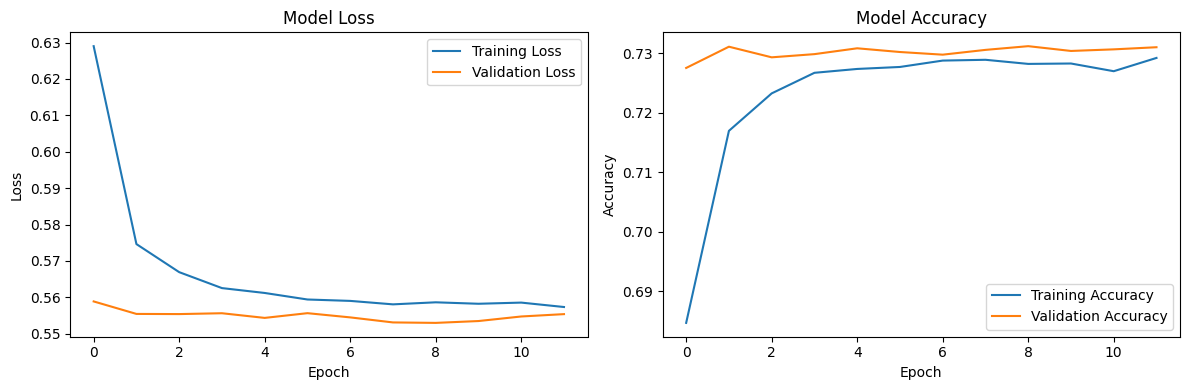

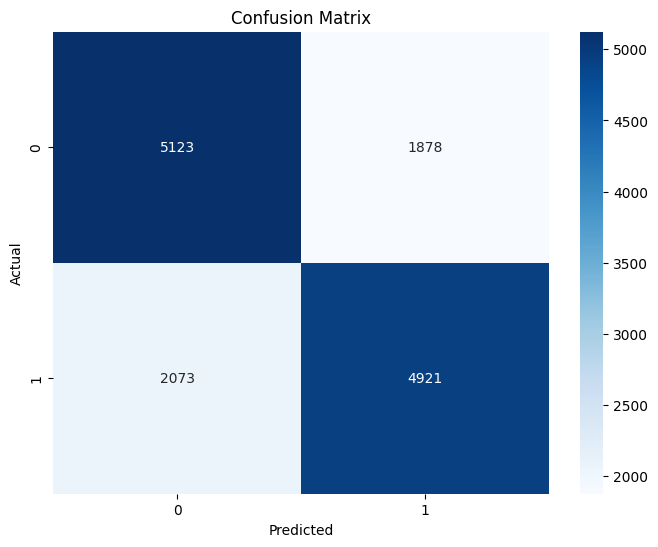

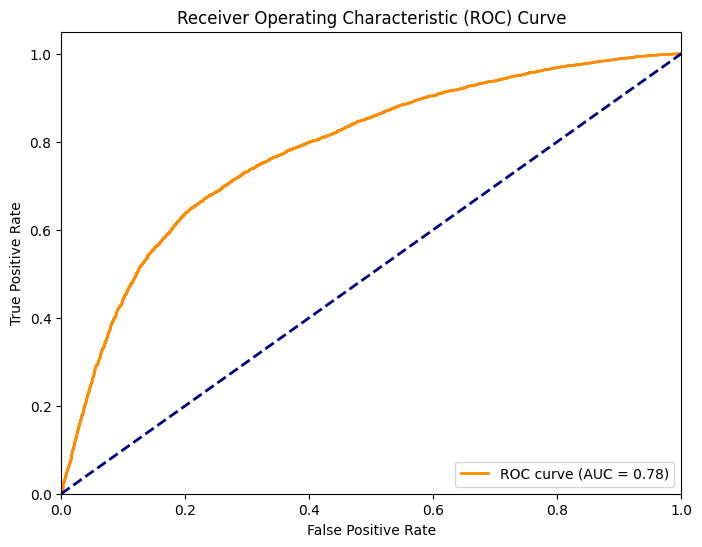

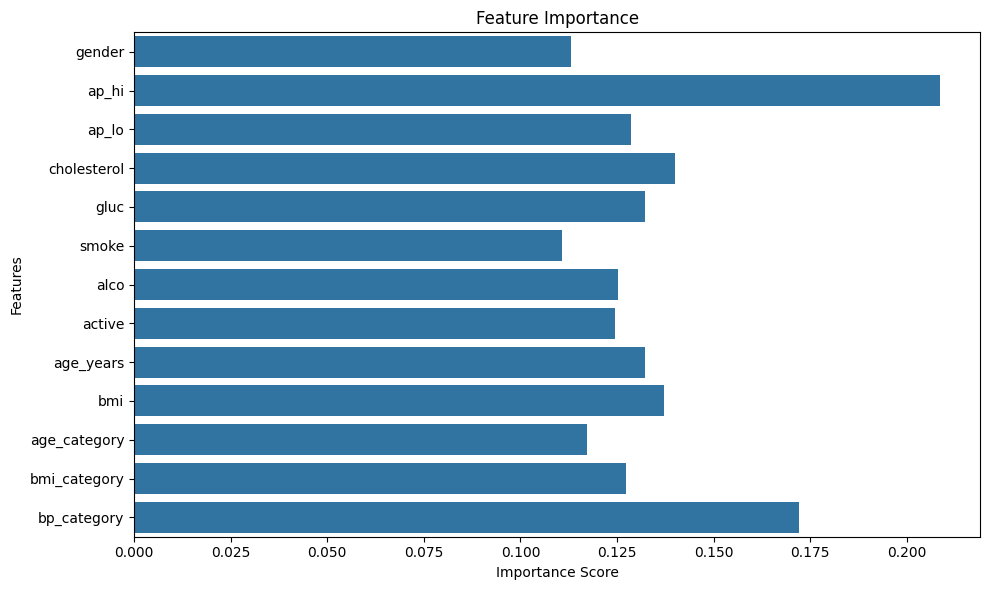

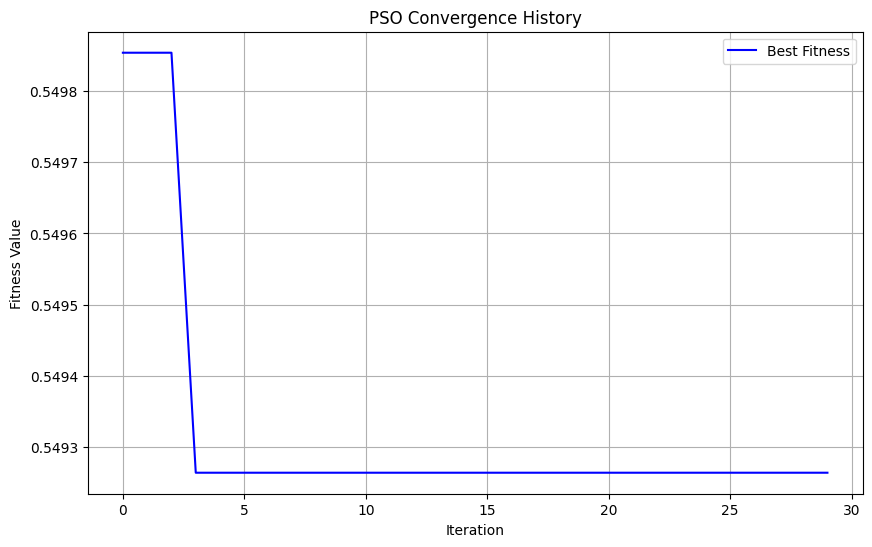

In [2]:
# Step 1: Check GPU Availability and Setup
import tensorflow as tf
print("GPU Available:", tf.config.list_physical_devices('GPU'))

# Enable memory growth for GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth enabled")
    except RuntimeError as e:
        print(e)

# Step 2: Import Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, confusion_matrix, roc_curve, auc)
import tensorflow as tf
from tensorflow import keras
import multiprocessing as mp
from concurrent.futures import ProcessPoolExecutor
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

# Step 3: Data Loading and Preprocessing
def load_and_preprocess_data():
    """Load and preprocess the cardiovascular dataset"""
    try:
        # Read the dataset
        df = pd.read_csv('C:/Users/hafiz/Downloads/cardio_train.csv')
        
        # Data cleaning
        # Replace any infinite values with NaN
        df = df.replace([np.inf, -np.inf], np.nan)
        
        # Drop rows with any NaN values
        df = df.dropna()
        
        # Feature engineering
        # Convert age from days to years
        df['age_years'] = df['age'] / 365.25
        
        # Calculate BMI
        df['bmi'] = df['weight'] / ((df['height']/100) ** 2)
        
        # Create age categories
        df['age_category'] = pd.cut(df['age_years'], 
                                   bins=[0, 30, 40, 50, 60, 70, 100],
                                   labels=[1, 2, 3, 4, 5, 6])
        
        # Create BMI categories
        df['bmi_category'] = pd.cut(df['bmi'],
                                   bins=[0, 18.5, 25, 30, 40, 100],
                                   labels=[1, 2, 3, 4, 5])
        
        # Create blood pressure categories
        df['bp_category'] = np.where((df['ap_hi'] < 120) & (df['ap_lo'] < 80), 1,
                                    np.where((df['ap_hi'] < 140) & (df['ap_lo'] < 90), 2, 3))
        
        # Drop unnecessary columns
        df = df.drop(['id', 'age', 'height', 'weight'], axis=1)
        
        # Check for any remaining NaN values
        if df.isnull().any().any():
            print("Warning: NaN values found after preprocessing")
            print("Columns with NaN values:", df.columns[df.isnull().any()].tolist())
            # Drop rows with NaN values
            df = df.dropna()
        
        # Split features and target
        X = df.drop('cardio', axis=1)
        y = df['cardio']
        
        # Split into train and test
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        
        # Scale features
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        
        # Convert to DataFrame to ensure no NaN values
        X_train = pd.DataFrame(X_train, columns=X.columns)
        X_test = pd.DataFrame(X_test, columns=X.columns)
        
        # Verify no NaN values before SMOTE
        if X_train.isnull().any().any() or X_test.isnull().any().any():
            print("Error: NaN values found after scaling")
            return None, None, None, None, None
        
        # Handle class imbalance
        try:
            smote = SMOTE(random_state=42)
            X_train, y_train = smote.fit_resample(X_train, y_train)
        except ValueError as e:
            print("Error during SMOTE:", str(e))
            print("Shape of X_train before SMOTE:", X_train.shape)
            print("Number of NaN values in X_train:", X_train.isnull().sum().sum())
            return None, None, None, None, None
        
        return X_train, X_test, y_train, y_test, X.columns
    
    except Exception as e:
        print("Error in data preprocessing:", str(e))
        return None, None, None, None, None

# Step 4: Neural Network Implementation
class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size):
        self.model = keras.Sequential([
            keras.layers.Input(shape=(input_size,)),
            keras.layers.Dense(hidden_size, activation='relu'),
            keras.layers.BatchNormalization(),
            keras.layers.Dropout(0.3),
            keras.layers.Dense(output_size, activation='sigmoid')
        ])
        
        # Add early stopping
        self.early_stopping = keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
        
        # Add learning rate scheduler
        self.lr_scheduler = keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=2,
            min_lr=1e-6
        )
        
        self.model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
    
    def train(self, X_train, y_train, epochs=100, batch_size=32):
        history = self.model.fit(
            X_train, y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_split=0.2,
            verbose=0,
            callbacks=[self.early_stopping, self.lr_scheduler]
        )
        self.history = history
        return history
    
    def evaluate(self, X_test, y_test):
        return self.model.evaluate(X_test, y_test, verbose=0)

# Step 5: PSO Implementation
class Particle:
    def __init__(self, dimensions):
        self.position = tf.random.uniform([dimensions], dtype=tf.float32)
        self.velocity = tf.random.uniform([dimensions], dtype=tf.float32)
        self.best_position = tf.identity(self.position)
        self.best_fitness = float('inf')
    
    def update_velocity(self, global_best, w, c1, c2):
        r1, r2 = tf.random.uniform([2], dtype=tf.float32)
        cognitive = c1 * r1 * (self.best_position - self.position)
        social = c2 * r2 * (global_best - self.position)
        self.velocity = w * self.velocity + cognitive + social
    
    def update_position(self):
        self.position = self.position + self.velocity
        self.position = tf.clip_by_value(self.position, 0, 1)

class PSO:
    def __init__(self, num_particles, dimensions):
        self.particles = [Particle(dimensions) for _ in range(num_particles)]
        self.global_best_position = None
        self.global_best_fitness = float('inf')
        self.v_max = 0.1
        self.fitness_history = []
    
    def optimize(self, objective_function, max_iterations):
        for iteration in range(max_iterations):
            fitnesses = []
            for particle in self.particles:
                fitness = objective_function(particle.position)
                fitnesses.append(fitness)
            
            for particle, fitness in zip(self.particles, fitnesses):
                if fitness < particle.best_fitness:
                    particle.best_fitness = fitness
                    particle.best_position = tf.identity(particle.position)
                    
                    if fitness < self.global_best_fitness:
                        self.global_best_fitness = fitness
                        self.global_best_position = tf.identity(particle.position)
            
            for particle in self.particles:
                particle.update_velocity(self.global_best_position, 0.7, 1.5, 1.5)
                particle.velocity = tf.clip_by_value(particle.velocity, -self.v_max, self.v_max)
                particle.update_position()
            
            self.fitness_history.append(self.global_best_fitness)
            
            if iteration % 5 == 0:
                print(f'Iteration {iteration+1}/{max_iterations}, Best Fitness: {self.global_best_fitness}')
        
        return self.global_best_position

# Step 6: PSO-NN Integration
class PSONeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.pso = PSO(num_particles=15, dimensions=5)
    
    def objective_function(self, hyperparameters):
        learning_rate = hyperparameters[0]
        batch_size = int(hyperparameters[1] * 64) + 64
        epochs = int(hyperparameters[2] * 20) + 10
        
        nn = NeuralNetwork(self.input_size, self.hidden_size, self.output_size)
        history = nn.train(X_train, y_train, epochs=epochs, batch_size=batch_size)
        
        return history.history['val_loss'][-1]
    
    def optimize(self, X_train, y_train, X_test, y_test):
        best_hyperparameters = self.pso.optimize(self.objective_function, max_iterations=30)
        
        learning_rate = best_hyperparameters[0]
        batch_size = int(best_hyperparameters[1] * 64) + 64
        epochs = int(best_hyperparameters[2] * 20) + 10
        
        final_nn = NeuralNetwork(self.input_size, self.hidden_size, self.output_size)
        final_nn.train(X_train, y_train, epochs=epochs, batch_size=batch_size)
        
        return final_nn

# Step 7: Visualization Functions
def plot_training_history(history):
    """Plot training and validation loss/accuracy over epochs"""
    plt.figure(figsize=(12, 4))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred):
    """Plot confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

def plot_roc_curve(y_true, y_pred_proba):
    """Plot ROC curve"""
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

def plot_feature_importance(model, feature_names):
    """Plot feature importance"""
    weights = model.model.layers[0].get_weights()[0]
    importance = np.abs(weights).mean(axis=1)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=importance, y=feature_names)
    plt.title('Feature Importance')
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.show()

def plot_pso_convergence(pso_history):
    """Plot PSO convergence history"""
    plt.figure(figsize=(10, 6))
    plt.plot(pso_history, 'b-', label='Best Fitness')
    plt.title('PSO Convergence History')
    plt.xlabel('Iteration')
    plt.ylabel('Fitness Value')
    plt.legend()
    plt.grid(True)
    plt.show()

# Step 8: Main Execution
if __name__ == "__main__":
    # Load and preprocess data
    print("Loading and preprocessing data...")
    X_train, X_test, y_train, y_test, feature_names = load_and_preprocess_data()
    
    # Check if data loading was successful
    if X_train is None:
        print("Error in data preprocessing. Please check the data and try again.")
        exit()
    
    # Initialize PSO-NN
    print("Initializing PSO-NN...")
    input_size = X_train.shape[1]
    hidden_size = 64
    output_size = 1
    pso_nn = PSONeuralNetwork(input_size, hidden_size, output_size)
    
    # Optimize and train
    print("Optimizing and training...")
    optimized_nn = pso_nn.optimize(X_train, y_train, X_test, y_test)
    
    # Get predictions
    y_pred_proba = optimized_nn.model.predict(X_test)
    y_pred = (y_pred_proba > 0.5).astype(int)
    
    # Evaluate
    print("Evaluating model...")
    loss, accuracy = optimized_nn.evaluate(X_test, y_test)
    print(f'Test Loss: {loss:.4f}')
    print(f'Test Accuracy: {accuracy:.4f}')
    
    # Calculate additional metrics
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print("\nAdditional Metrics:")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    # Generate visualizations
    print("\nGenerating visualizations...")
    plot_training_history(optimized_nn.history)
    plot_confusion_matrix(y_test, y_pred)
    plot_roc_curve(y_test, y_pred_proba)
    plot_feature_importance(optimized_nn, feature_names)
    plot_pso_convergence(pso_nn.pso.fitness_history)